<a href="https://colab.research.google.com/github/omaeewa/SimpsonsClassifier/blob/main/SimpsonsClasifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка набора данных

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omaeewa","key":"a854692192df02ab59d31214a0c1fd60"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c journey-springfield

100% 520M/521M [00:27<00:00, 21.3MB/s]
100% 521M/521M [00:27<00:00, 19.6MB/s]


In [ ]:
!unzip journey-springfield.zip


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = datasets.ImageFolder('/content/train/simpsons_dataset', transform=transform)

val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


Визуализация данных с измененным размером но не нормализированных

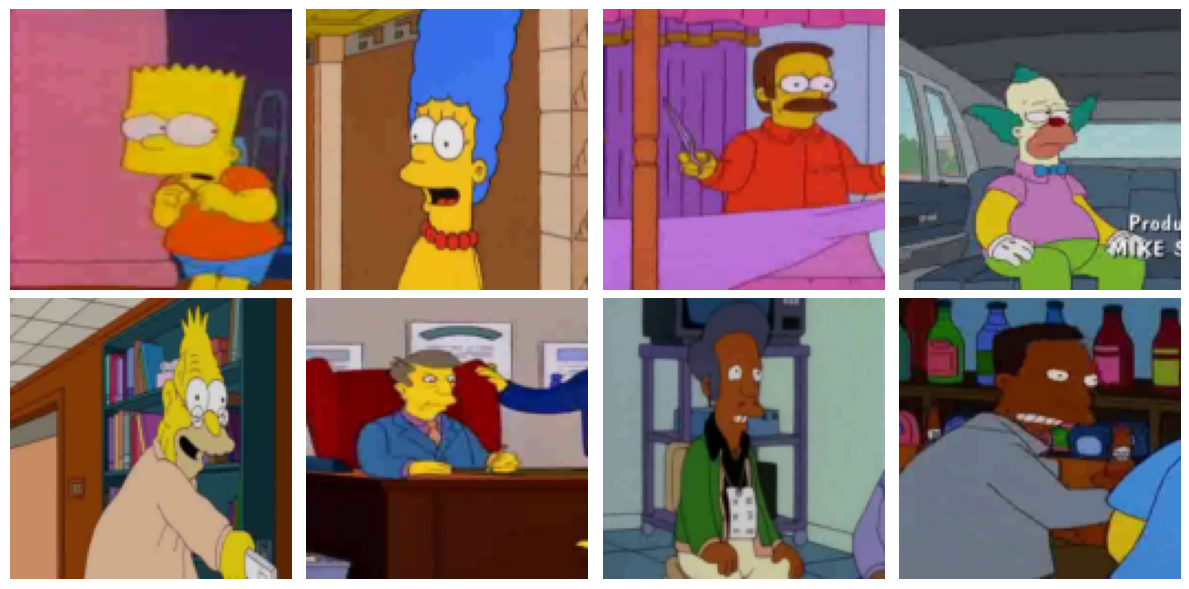

In [ ]:
import random
import matplotlib.pyplot as plt

transform_without_norm = transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

not_normalized_dataset = datasets.ImageFolder('/content/train/simpsons_dataset', transform=transform_without_norm)
random_indices = random.sample(range(len(not_normalized_dataset)), 8)
images = [not_normalized_dataset[i] for i in random_indices]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, img in enumerate(images):
    ax = axs[i // 4, i % 4]
    img = img[0].permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:



class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



cuda:0


In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_preds, total_examples = 0, 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted_labels = torch.max(outputs, 1)
        correct_preds += (predicted_labels == labels).sum().item()
        total_examples += labels.size(0)
    return correct_preds / total_examples * 100

In [ ]:
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Обучение завершено!")

Epoch [1/10], Loss: 1.0109
Epoch [2/10], Loss: 1.1049
Epoch [3/10], Loss: 0.9177
Epoch [4/10], Loss: 0.2055
Epoch [5/10], Loss: 0.0466
Epoch [6/10], Loss: 0.1051
Epoch [7/10], Loss: 0.0987
Epoch [8/10], Loss: 0.2852
Epoch [9/10], Loss: 0.0954
Epoch [10/10], Loss: 0.2849
Обучение завершено!


In [ ]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
      correct_preds, total_examples = 0, 0
      for inputs, labels in data_loader:
         inputs, labels = inputs.to(device), labels.to(device)
         outputs = model(inputs)
         _, predicted_labels = torch.max(outputs, 1)
         correct_preds += (predicted_labels == labels).sum().item()
         total_examples += labels.size(0)
      return correct_preds / total_examples * 100


In [ ]:


train_accuracy = compute_accuracy(model, train_loader, device)
val_accuracy = compute_accuracy(model, val_loader, device)
print(f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


Training Accuracy: 97.83%, Validation Accuracy: 78.07%


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_dataset = datasets.ImageFolder('/content/testset', transform=transform)

In [ ]:
class_to_idx = train_dataset.class_to_idx
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}


In [ ]:
filenames = []
predictions = []

model.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        image, _ = test_dataset[i]
        image_path = test_dataset.imgs[i][0]  # путь к текущему изображению
        image_name = image_path.split('/')[-1]  # имя файла изображения
        filenames.append(image_name)

        image = image.to(device).unsqueeze(0)
        outputs = model(image)
        predicted_class_idx = torch.argmax(outputs, dim=1).item()
        predicted_class_name = idx_to_class[predicted_class_idx]
        predictions.append(predicted_class_name)



На kaggle показало 97% score

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'Id': filenames,
    'Expected': predictions
})
df
df.to_csv('predictions.csv', index=False)

In [ ]:
df

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,homer_simpson
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
